# Image Classification - Mobilenet model (TFLite)
Developed by Marcelo Rovai - 19Aug20

Reference: [TensorFlow Lite inference](https://www.tensorflow.org/lite/guide/inference)<br>
Also see:
- [Python quickstart](https://www.tensorflow.org/lite/guide/python)
- [Image classification](https://www.tensorflow.org/lite/models/image_classification/overview)

The term inference refers to the process of executing a TensorFlow Lite model on-device in order to make predictions based on input data. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. The interpreter uses a static graph ordering and a custom (less-dynamic) memory allocator to ensure minimal load, initialization, and execution latency.

## Install just the TensorFlow Lite interpreter

To quickly run TensorFlow Lite models with Python, you can install just the TensorFlow Lite interpreter, instead of all TensorFlow packages.

For example, if you have Raspberry Pi that's running Raspbian Buster (which has Python 3.7), install the Python wheel as follows:

`$ sudo pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp37-cp37m-linux_armv7l.whl`

## Libraries and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tflite_runtime.interpreter as tflite

## Load Model

`$ mkdir models` <br>
`$ cd models` <br>
`$ wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/mobilenet_v1_1.0_224_quant_and_labels.zip`<br>

`$ unzip mobilenet_v1_1.0_224_quant_and_labels`

Two files will be downloaded:
    - mobilenet_v1_1.0_224_quant.tflite:  TensorFlow-Lite transformed model 
    - labels_mobilenet_quant_v1_224.txt: The ImageNet dataset 1,000 Classes Labels

In [2]:
!ls ./models

labels_mobilenet_quant_v1_224.txt  mobilenet_v1_1.0_224_quant.tflite


### Load TFLite model and allocate tensors

In [3]:
interpreter = tflite.Interpreter(
    model_path='./models/mobilenet_v1_1.0_224_quant.tflite')
interpreter.allocate_tensors()

### Get input and output tensors.

In [4]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
input_details

[{'name': 'input',
  'index': 88,
  'shape': array([  1, 224, 224,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128]),
   'quantized_dimension': 0}}]

In [6]:
output_details

[{'name': 'MobilenetV1/Predictions/Reshape_1',
  'index': 87,
  'shape': array([   1, 1001]),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0}}]

### Load model labels

In [7]:
def load_labels(path):
    with open(path, 'r') as f:
        return {i: line.strip() for i, line in enumerate(f.readlines())}

In [8]:
labels = load_labels('./models/labels_mobilenet_quant_v1_224.txt')

In [9]:
type(labels)

dict

In [10]:
len(labels)

1001

In [11]:
labels.get(0)

'background'

In [12]:
labels.get(1000)

'toilet tissue'

In [13]:
for x in range(10): print(x, labels.get(x))

0 background
1 tench
2 goldfish
3 great white shark
4 tiger shark
5 hammerhead
6 electric ray
7 stingray
8 cock
9 hen


### Get input size.

In [14]:
input_shape = input_details[0]['shape']
img_size = input_shape[:2] if len(input_shape) == 3 else input_shape[1:3]

In [15]:
input_shape

array([  1, 224, 224,   3])

In [16]:
img_size

array([224, 224])

In [17]:
w, h = img_size[0],img_size[1]
w, h

(224, 224)

## Test on a real image

In [18]:
!ls images

beagles.jpg  car_5.jpg	cat_dog.jpeg	dog_4.jpg	  table.jpg
beatch.jpg   cat_1.jpg	cat.png		man_cat_dog.jpeg  tiger.jpg
bulldog.jpg  cat_2.jpg	cats_dogs.jpeg	mixed.jpeg	  tina_0.jpeg
car_1.jpg    cat_2.png	doberman.jpg	office.jpeg
car_2.jpg    cat_3.jpg	dog_1.jpg	pi_1.jpeg
car_3.jpg    cat_4.jpg	dog_2.jpg	ship_1.jpg
car_4.jpg    cat_5.jpg	dog_3.jpg	ship_2.jpg


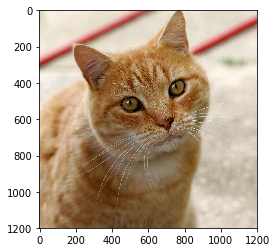

In [43]:
image_path = './images/cat_2.jpg'
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img);

### Preprocess image

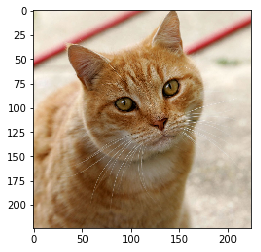

In [44]:
img = cv2.resize(img, (w,h)) 
plt.imshow(img);

In [45]:
img.shape

(224, 224, 3)

### Add a batch dimension
This is necessary to match the input tensor shape (1, 224, 224, 3)

In [46]:
input_data = np.expand_dims(img, axis=0)

In [47]:
input_data.shape

(1, 224, 224, 3)

### Point the data to be used for testing and run the interpreter

In [48]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 176 ms


In [49]:
# Obtain results and map them to the classes
%time predictions = interpreter.get_tensor(output_details[0]['index'])[0]

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 79.2 µs


In [33]:
predictions.shape

(1001,)

In [34]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
# Get indices of the top k results
top_k_results = 3
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

In [37]:
top_k_indices

array([286, 283, 282], dtype=int32)

In [36]:
print(labels.get(286))
print(labels.get(283))
print(labels.get(282))

Egyptian cat
tiger cat
tabby


In [29]:
print (predictions[286])
print (predictions[283])
print (predictions[282])

156
57
30


In [30]:
output_details[0]['dtype']

numpy.uint8

Looking the output tensor, we see that the model is quantized, so predition is an 8 bits integer (uint8),that goes from 0 to 255. So, it is necessary to 'dequantize' the results dividing preditions by 255.0, in order to get the probability between 0 and 1

In [31]:
print (predictions[286]/255.0)
print (predictions[283]/255.0)
print (predictions[282]/255.0)

0.611764705882353
0.2235294117647059
0.11764705882352941


Creating a general loop to print the result:

In [38]:
for i in range(top_k_results):
    print(labels[top_k_indices[i]], round((predictions[top_k_indices[i]] / 255.0), 2))

Egyptian cat 0.61
tiger cat 0.22
tabby 0.12


In [39]:
for i in range(top_k_results):
    print("\t{:20}: {}%".format(
        labels[top_k_indices[i]],
        int((predictions[top_k_indices[i]] / 255.0) * 100)))

	Egyptian cat        : 61%
	tiger cat           : 22%
	tabby               : 11%


### Testing in more images

In [50]:
top_k_results = 3
image_path = './images/cat_2.jpg'

Egyptian cat 0.611764705882353
tiger cat 0.2235294117647059
tabby 0.11764705882352941
CPU times: user 349 ms, sys: 116 ms, total: 464 ms
Wall time: 472 ms


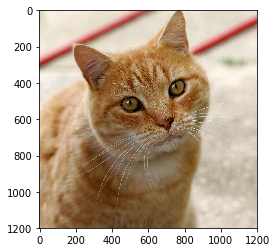

In [51]:
%%time
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img);

# Preprocess image
img = cv2.resize(img, (w,h)) 

### Add a batch dimension
input_data = np.expand_dims(img, axis=0)

# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

# Get indices of the top k results
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

for i in range(top_k_results):
    print(labels[top_k_indices[i]], predictions[top_k_indices[i]] / 255.0)

### Bilding a function

In [52]:
def image_classification(image_path, labels, top_k_results=3):
    image = cv2.imread(image_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

    # Preprocess image
    img = cv2.resize(img, (w, h))

    ### Add a batch dimension
    input_data = np.expand_dims(img, axis=0)

    # Point the data to be used for testing and run the interpreter
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Obtain results and map them to the classes
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {}%".format(
            labels[top_k_indices[i]],
            int((predictions[top_k_indices[i]] / 255.0) * 100)))


	[PREDICTION]        [Prob]

	Egyptian cat        : 61%
	tiger cat           : 22%
	tabby               : 11%
CPU times: user 353 ms, sys: 86.5 ms, total: 440 ms
Wall time: 443 ms


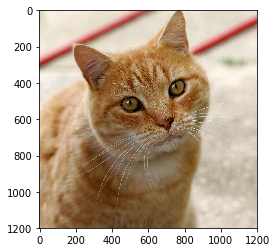

In [54]:
image_path = './images/cat_2.jpg'
%time image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	Egyptian cat        : 64%
	tabby               : 14%
	bucket              : 3%


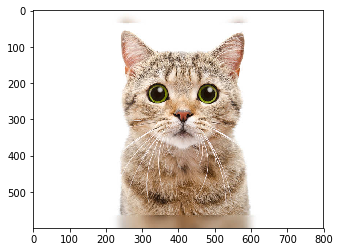

In [40]:
image_path = './images/cat_1.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 83%
	golden retriever    : 13%
	bloodhound          : 0%


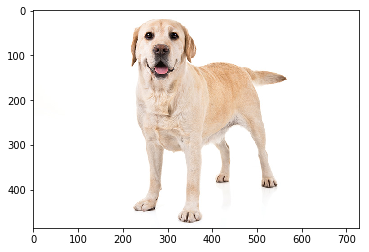

In [41]:
image_path = './images/dog_1.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	Doberman            : 96%
	Rottweiler          : 2%
	miniature pinscher  : 0%


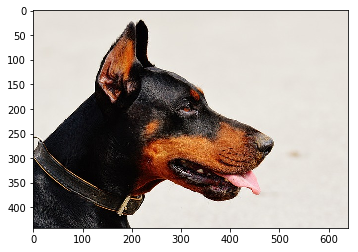

In [42]:
image_path = './images/doberman.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	German shepherd     : 60%
	dhole               : 16%
	malinois            : 7%


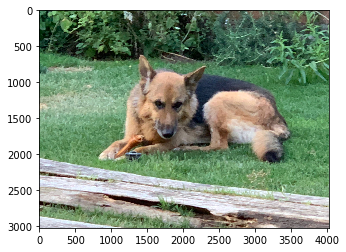

In [44]:
image_path = './images/pi_1.jpeg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	tiger               : 99%
	tiger cat           : 0%
	toilet tissue       : 0%


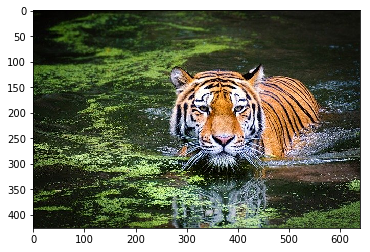

In [45]:
image_path = './images/tiger.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	sports car          : 96%
	racer               : 1%
	beach wagon         : 1%


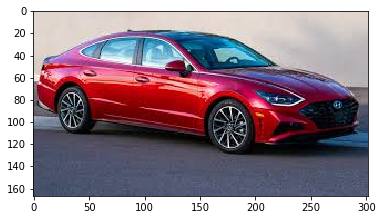

In [46]:
image_path = './images/car_1.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	minivan             : 76%
	convertible         : 6%
	jeep                : 4%


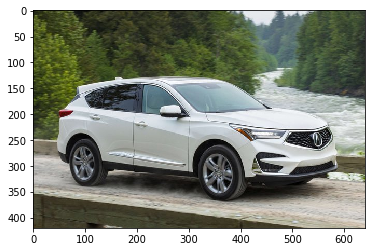

In [47]:
image_path = './images/car_2.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	liner               : 85%
	trimaran            : 11%
	aircraft carrier    : 0%


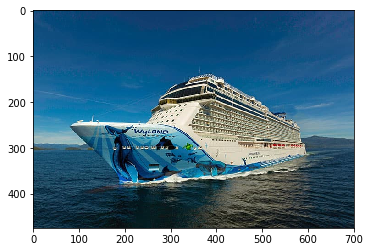

In [48]:
image_path = './images/ship_1.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	dining table        : 40%
	table lamp          : 34%
	desk                : 17%


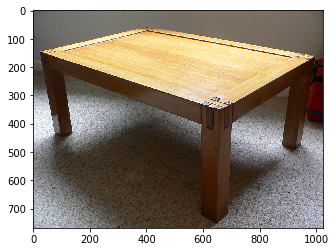

In [49]:
image_path = './images/table.jpg'
image_classification(image_path, labels)

### Test with multiple Images


	[PREDICTION]        [Prob]

	pirate              : 53%
	schooner            : 45%
	drilling platform   : 0%


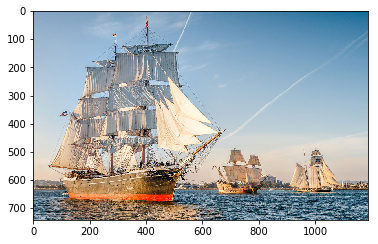

In [50]:
image_path = './images/ship_2.jpg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	ashcan              : 27%
	Egyptian cat        : 19%
	hamper              : 13%


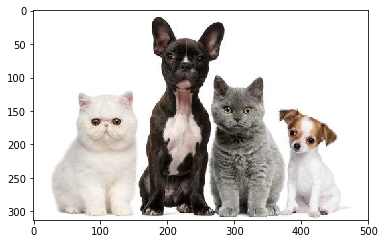

In [51]:
image_path = './images/cats_dogs.jpeg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	basenji             : 34%
	beagle              : 21%
	whippet             : 9%


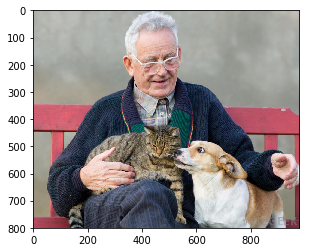

In [52]:
image_path = './images/man_cat_dog.jpeg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	crate               : 28%
	West Highland white terrier: 14%
	miniature schnauzer : 10%


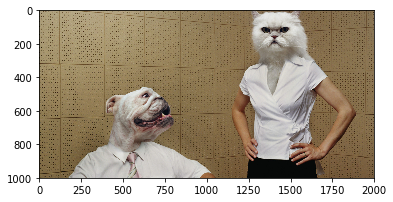

In [53]:
image_path = './images/mixed.jpeg'
image_classification(image_path, labels)


	[PREDICTION]        [Prob]

	revolver            : 5%
	neck brace          : 5%
	barbershop          : 4%


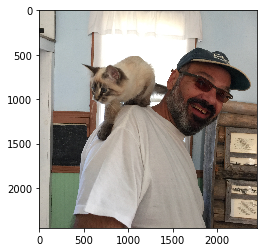

In [54]:
image_path = './images/tina_0.jpeg'
image_classification(image_path, labels)